# 主成分分析

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [2]:
class PCA(object):
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X):
        self.mean = X.mean(axis=0)
        
        # X.T.dot(X)
        cov = np.cov(X - self.mean, rowvar=False)
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(cov)
        self.W = self.eigenvectors[:, -self.n_components:]
        
        self.principal_components = self.W.T[::-1]
        
        contribution_rate = self.eigenvalues / self.eigenvalues.sum()
        self.contribution_rate = contribution_rate[-self.n_components:][::-1]
    
    def transform(self, X):
        return (X - self.mean).dot(self.W)
    
    def inverse_transform(self, Z):
        return Z.dot(self.W.T) + self.mean

## 2次元データの無相関化

(-5, 5)

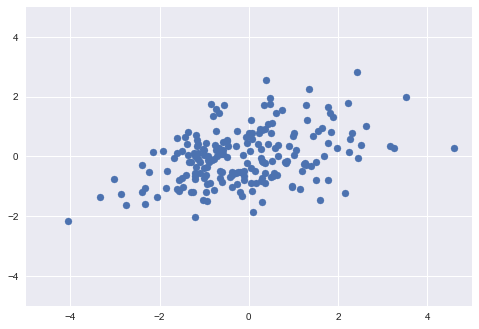

In [3]:
mean = [0, 0]
cov = [[2, 0.7], [0.7, 1]]
# データセット生成
X = np.random.multivariate_normal(mean, cov, 200)

# データを図示
plt.scatter(X[:, 0], X[:, 1])
plt.xlim(-5, 5)
plt.ylim(-5, 5)

(-5, 5)

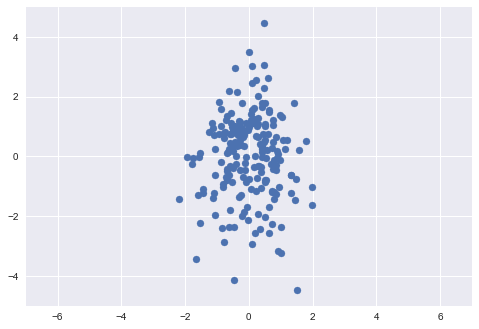

In [4]:
# 主成分分析インスタンスを作り、データを学習
pca = PCA(2)
pca.fit(X)
# データを線形変換
Z = pca.transform(X)

# 線形変換したデータを図示
plt.scatter(Z[:, 0], Z[:, 1])
plt.xlim(-7, 7)
plt.ylim(-5, 5)

### 逆変換

(-5, 5)

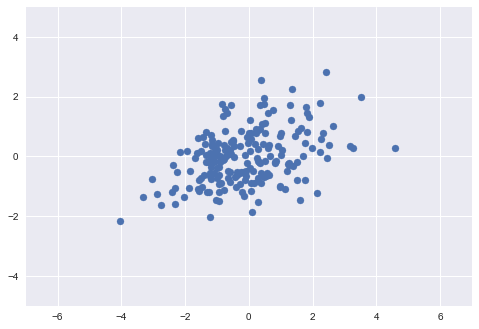

In [5]:
# 線形変換されたデータを逆変換
_X = pca.inverse_transform(Z)

# 逆変換されたデータを図示
plt.scatter(_X[:, 0], _X[:, 1])
plt.xlim(-7, 7)
plt.ylim(-5, 5)

### 主成分

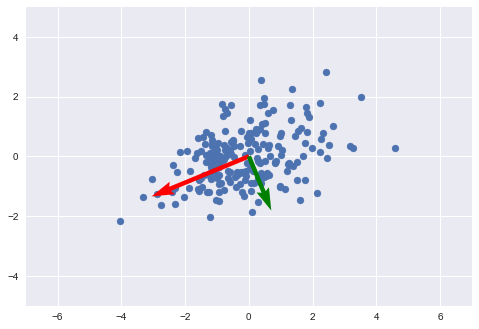

In [6]:
# 主成分と対応する標準偏差
first, second = pca.principal_components
std2, std1 = np.sqrt(pca.eigenvalues)

plt.scatter(X[:, 0], X[:, 1])
plt.xlim(-7, 7)
plt.ylim(-5, 5)
# 第１主成分
plt.quiver(0, 0, first[0], first[1], width=0.01, scale=6/std1, color='red')
# 第２主成分
plt.quiver(0, 0, second[0], second[1], width=0.01, scale=6/std2, color='green')

## 3次元データの次元削減

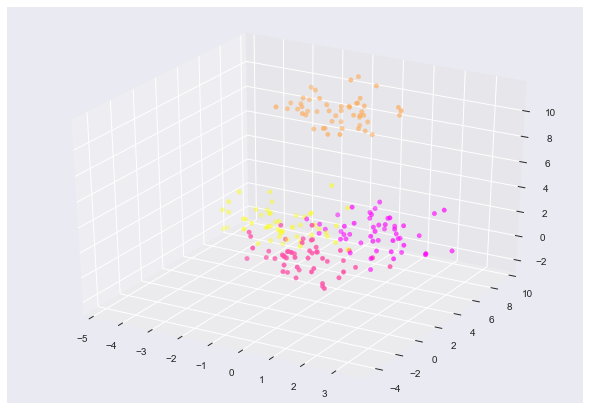

In [7]:
from sklearn.datasets.samples_generator import make_blobs
# データセット生成
X, y = make_blobs(n_samples=200, n_features=3, centers=4,
                  random_state=0, cluster_std=1.0)

# 図示
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='spring')

In [8]:
# ３次元データを２次元に次元削減
pca = PCA(2)
pca.fit(X)

### 写像する平面を図示

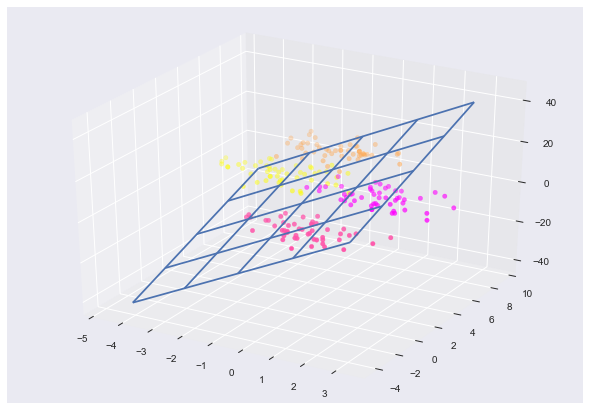

In [9]:
def plot_2d_plane(pca, ax):
    # 第１主成分と第２主成分に平行な平面を図示
    a = np.cross(pca.principal_components[0], pca.principal_components[1])
    x = np.linspace(ax.get_xlim()[0]*0.8, ax.get_xlim()[1]*0.8, 5)
    y = np.linspace(ax.get_ylim()[0]*0.8, ax.get_ylim()[1]*0.8, 5)
    Y, X = np.meshgrid(y, x)
    Z = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            Z[i, j] = - (a[0]*xi + a[1]*yj) / a[2]
    ax.plot_wireframe(X, Y, Z)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='spring')
plot_2d_plane(pca, ax)

### ２次元へ写像した結果を図示

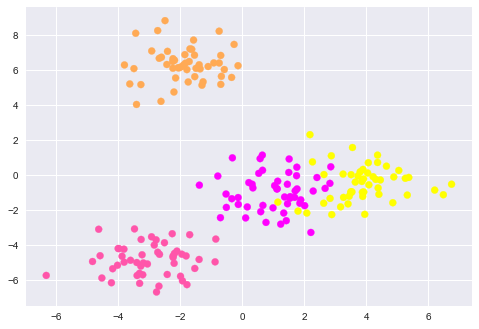

In [10]:
Z = pca.transform(X)
plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='spring')

## MNIST

In [11]:
from sklearn.datasets import fetch_mldata
# MNISTデータ取得
mnist = fetch_mldata('MNIST original')

In [12]:
# 一部のみ使用（数字6）
X = mnist.data[mnist.target == 6][:200]
X.shape

(200, 784)

In [13]:
# 784次元を10次元に次元削減
pca = PCA(10)
pca.fit(X)
# 主成分の寄与率
print(pca.contribution_rate)
print('total:', pca.contribution_rate.sum())

[ 0.15757278  0.12330749  0.09000445  0.05878545  0.05175003  0.04432438
  0.03182319  0.0294577   0.02699479  0.02343586]
total: 0.637456134006


### 主成分を図示

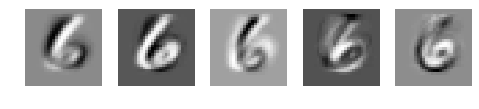

In [14]:
plt.figure()
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pca.principal_components[i].reshape(28, 28))
    plt.axis('off')

### 次元削減し再構成

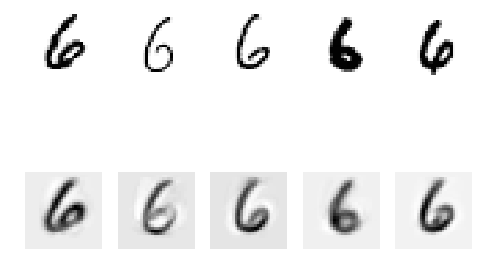

In [15]:
x = X[:5]
# 784次元を3次元に
z = pca.transform(x)
# 3次元を784次元に
x_ = pca.inverse_transform(z)

plt.figure()
for i in range(5):
    # 上段が元の画像
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i].reshape(28, 28))
    plt.axis('off')
    
    # 下段が再構成した画像
    plt.subplot(2, 5, i+6)
    plt.imshow(x_[i].reshape(28, 28))
    plt.axis('off')

## 主成分分析を用いた回帰

In [16]:
# データセット生成（説明変数は４次元）
n = 500
X = 5 * np.random.rand(n, 4)
# x3とx4に相関あり
X[:, 3] += 2 * X[:, 2]
Ey = 0.2 * X[:, 0] + 0.3 * X[:, 1] + 0.1 * X[:, 2] + 0.5 * X[:, 3]
y = Ey + np.random.normal(size=(n,))

In [17]:
def split_train_test(X, y):
    # 訓練データとテストデータを分ける
    from sklearn.utils import shuffle
    X, y = shuffle(X, y)
    n_train = int(len(y) * 0.8) 
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

In [18]:
X_train, y_train, X_test, y_test = split_train_test(X, y)

# ４次元を２次元に次元削減
pca = PCA(2)
pca.fit(X_train)

### 説明変数を次元削減かつ無相関化

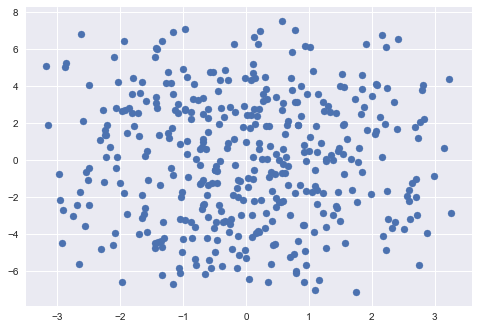

In [19]:
z = pca.transform(X_train)
plt.scatter(z[:, 0], z[:, 1])

### もとの説明変数と次元削減した説明変数に対して線形回帰

In [20]:
# 線形回帰
from sklearn.linear_model import LinearRegression

# もとの説明変数で回帰
model = LinearRegression()
model.fit(X_train, y_train)

# 次元削減かつ無相関化した説明変数で回帰
model_pca = LinearRegression()
model_pca.fit(z, y_train)

/Users/sasakiwataru/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
# R^2値
print('original:', model.score(X_test, y_test))
print('pca:', model_pca.score(pca.transform(X_test), y_test))

original: 0.742167032075
pca: 0.750656189939


### 予測値と実測値の相関

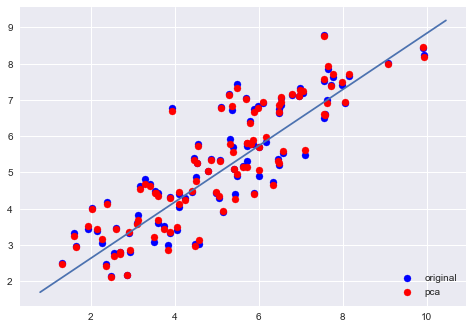

In [22]:
plt.scatter(y_test, model.predict(X_test), c='b', label='original')
plt.scatter(y_test, model_pca.predict(pca.transform(X_test)), c='r', label='pca')
plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.ylim()[0], plt.ylim()[1]])
plt.legend(loc='lower right')